# A brief introduction to machine learning in environmental science

The goal of this interactive presentation is to demonstrate how machine learning can help us understand and predict environmental processes. We'll work through a problem that comes from my own research and see how we can use a few particular algorithms from the machine learning world to solve it. Along the way, I will emphasize the practical aspects of machine learning. You probably won't ever work on the exact problem that I will show you, or use the exact same tools, but there are some fundamental ideas to creating models, fitting them and testing them that will carry over if you do find a problem that you want to tackle with machine learning.

This interactive notebook will always be available to you at https://github.com/wkearn/evsc4002-machine-learning. Feel free to send me an email ([wkearn@virginia.edu](mailto:wkearn@virginia.edu)) or stop by my office (Clark 357) if you have any more questions!

## Outline

0. Using the Jupyter notebook
1. What is machine learning?
2. The problem of estimating tidal flows from water levels
3. A classical semi-empirical model
4. A nonlinear time series model

## Jupyter and Julia

This [Jupyter](https://jupyter.org/) notebook provides an interactive environment that we'll use to run code that will train machine learning models on some data that I will provide to you. The notebook allows you to run code and visualize the results immediately.

Jupyter notebooks are divided into cells. If you click on this text, you'll see a blue bar to the left that highlight's the current cell. There are two kinds of cells. This cell is a Markdown cell, which contains text written in the Markdown format. 

The next cell is a code cell, which contains code that can be run.

In [2]:
# This is a code cell. 
# Highlight this cell and press `Shift-Enter` to execute the code within the cell
1+1

2

To edit a code cell, click on it. To edit a Markdown cell, double click, and you will be able to type in the cell. If you are in editing mode, `Shift-Enter` will still execute the code and move you to the next cell. Press `ESC` or click on another cell to get out of the editing mode without executing the cell.

To change the type of a cell from Markdown to code or vice versa, you can highlight the cell and then use the dropdown menu on the toolbar. You can also use a keyboard shortcut from the highlight mode (they won't work if you are in editing mode. Press `ESC` to get out of editing mode then use the shortcut):

- `y` will convert a Markdown cell to a code cell
- `m` will convert a code cell to a Markdown cell 

Jupyter notebooks can run code written in a variety of programming languages including Python and R. This notebook runs code in the [Julia](http://julialang.org/) programming language, which I use for all of my research. Don't worry if you've never programmed before or if you have, but you don't have any experience with Julia. I've written the examples so that you can run them without writing any code. Some of the examples will have parameters that you can play with to see how they change your output, but those will be clearly marked and will usually just require you to change a number in the code.

In [3]:
# This code tests whether the expression on the right equals that on the left.
# Change the value on the right to make the test return `true` and execute the cell
# to check your work.

1 + 1 == 3

false

We'll need a few packages to load our data, train our models and visualize our results. Julia is designed to be a really fast language, but one thing that can take a while is loading packages. We'll load these packages while we move on to the next part.

In [10]:
using Plots, Clustering, LinearAlgebra, NetCDF, 
DelimitedFiles,  StatsBase, Statistics, Optim,
FileIO
import Distances: pairwise, Euclidean
gr(format=:png,size=(400,300))
theme(:wong)

## What is machine learning?

Machine learning is the art and science of training computers to recognize patterns in data and to apply those patterns to accomplish a given task. An example of these tasks that is commonly studied in machine learning is **unsupervised classification**, trying to separate data into natural clusters.

Imagine we have data that looks like this:

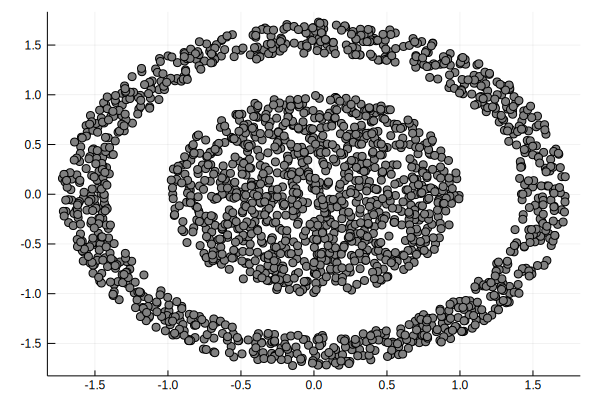

In [11]:
U = rand(1000,2)
V = rand(1000,2)
R = U.+[0,2]'
θ = 2pi*V
X = sqrt.(R).*cos.(θ)
Y = sqrt.(R).*sin.(θ)
scatter(X,Y,c=:grey,leg=false)

We can see that these data points separate naturally into two clusters based on their distance from the origin. The unsupervised classification task is to label each point with its cluster membership. 

One algorithm that is commonly applied to this task is **k-means clustering** ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)), which defines each cluster by a *centroid*, a point in the data space. Each data point is assigned to the cluster whose centroid is closest to it. The k-means algorithm iteratively adjusts the location of these centroids until it finds the locations where the total distance between each of the points and its assigned centroid is minimized.

Julia's [Clustering.jl](https://clusteringjl.readthedocs.io/en/latest/kmeans.html) package has an implementation of k-means clustering that we can use.

In [13]:
# We need a matrix that holds each sample in an individual column
D = [vec(X)'; vec(Y)'] 

# The first argument to the `kmeans` function is the data matrix, 
# the second is the number of clusters
kmeans_result = kmeans(D,2) 

KmeansResult{Float64}([-0.232789 0.248577; -0.673435 0.698626], [1, 2, 2, 2, 1, 1, 1, 1, 1, 1  …  1, 2, 2, 1, 2, 1, 2, 2, 1, 2], [0.243378, 0.546764, 0.67355, 0.198754, 0.726365, 1.09169, 0.218949, 0.323505, 0.829429, 0.158922  …  1.72369, 2.74388, 0.828736, 1.72962, 2.02385, 2.1347, 0.498849, 0.84391, 1.36439, 0.764693], [1028, 972], [1028.0, 972.0], 1945.1779764158687, 47, true)

We can extract the cluster assignments from the k-means result and plot them.

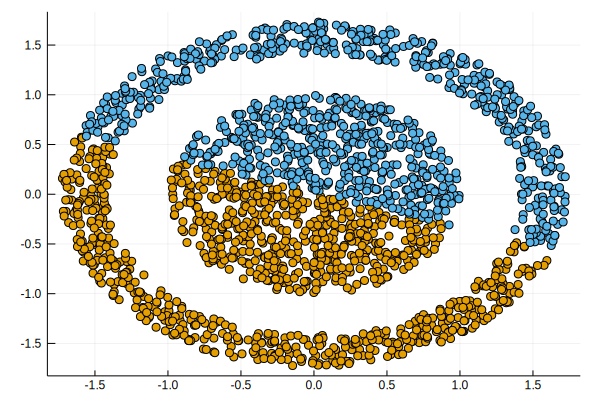

In [15]:
kmeans_assignments = assignments(kmeans_result)
p = plot(leg=false)
scatter!(D[1,kmeans_assignments.==1],D[2,kmeans_assignments.==1])
scatter!(D[1,kmeans_assignments.==2],D[2,kmeans_assignments.==2])


Hmm. That doesn't seem to have worked. Why not?

We can use another tool (often called the **kernel trick**) to cluster these data correctly.

The details aren't super important, but we're basically going to run two transformations on our data:

1. Compute a nonlinear kernel that encodes our knowledge of how the clusters should separate in space.
2. Apply something like principal components analysis (which you may have encountered before in a stats class) to the kernel to transform our data into a new space in which they are linearly separable, so k-means will work.

This technique is called [spectral clustering](https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf).

In [16]:
# This is our kernel function, a Gaussian radial basis function
k(d,σ=1.0) = exp.(-σ*d.^2)

# We first calculate a distance matrix, 
#then we apply our kernel function to our 
# distance matrix to get a kernel matrix
K = k.(pairwise(Euclidean(),D),100)
# We have to normalize it in a particular way
D2 = diagm(0=>vec(1.0./sqrt.(sum(K,dims=2))))
L = Symmetric(D2*K*D2)

# This is some linear algebra that computes 
# the principal components analysis
l,Z = eigen(L);

H = Z[:,end-1:end]
# Here we create a transformed data matrix 
# and run k-means on the transformed data.
D2 = Matrix(H')
kmeans2 = kmeans(D2,2);

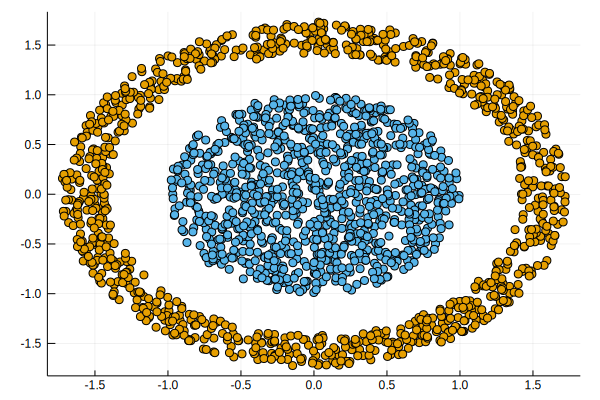

In [18]:
kmeans_assignments2 = assignments(kmeans2)
p = plot(leg=false)
scatter!(D[1,kmeans_assignments2.==1],D[2,kmeans_assignments2.==1])
scatter!(D[1,kmeans_assignments2.==2],D[2,kmeans_assignments2.==2])

The details of this example are not particularly important because you are rarely going to see a problem like this one in real life. What is important is to realize that machine learning boils down to **pattern recognition**. Our human perception has evolved over millions of years to be good at this task: we can clearly see even from the unlabeled data that there are two clusters in these data, depending on their radial distance from the origin. But computers are not so sophisticated. Simple algorithms, like k-means, are powerful when data meet their assumptions, but we have to be careful with more complicated datasets.

### Other tasks in machine learning

We just looked at an example of unsupervised classification or clustering. But there are many other tasks that machine learning practitioners would like to do. Many of these other tasks fall into the category of **supervised learning**, in which the data points come with labels that we want to predict. If these labels are discrete, i.e. classes, we have **supervised classification**. If they are continuous, we have a **regression** problem, which you might be familiar with from statistics classes.

# Estimating tidal flows from water levels

![](figures/sweeney.png)

One interesting way to study salt marshes is to look at the flux of material into and out of the marsh. For instance, marshes need a steady supply of sediment to accrete as sea level rises, so if we measure the amount of sediment that flows into a marsh on the flood tide and the amount that comes out on the ebb tide, we can determine whether a marsh is gaining or losing sediment (and thus elevation relative to sea level).

However, it can be tricky to make good measurements of the flow of water in marsh creeks, so one question is whether we can use something that is easier to measure, like the water level, to estimate what the flow is.

What we need is a model that relates water level (also called **stage**) to flow (also called **discharge**, a **stage-discharge model** or **rating curve**. Building these rating curves is how [the USGS estimates discharges](https://maps.waterdata.usgs.gov/mapper/index.html) in streams across the country. For example, here is a rating curve used by the USGS to estimate [discharges on the Rivanna River at Palmyra](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=02034000).

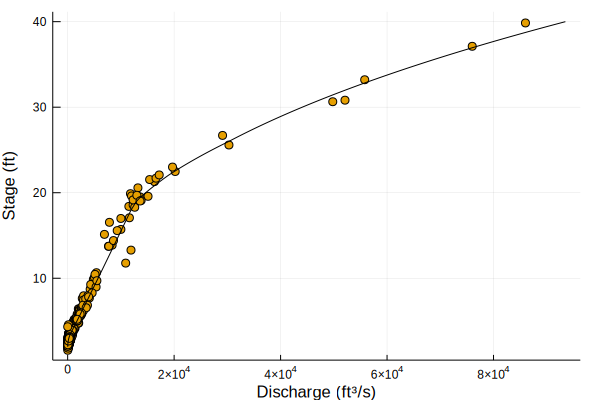

In [21]:
palmyra_data = readdlm("data/rating_data.csv",header=true)[1]
palmyra_curve = readdlm("data/rating.csv",header=true)[1]
palmyra_h = float.(palmyra_curve[:,1])
palmyra_q = float.(palmyra_curve[:,3])
scatter(palmyra_data[:,2],palmyra_data[:,1])
plot!(palmyra_q,palmyra_h,c=:black,leg=false,
    ylabel="Stage (ft)",xlabel="Discharge (ft³/s)")

The USGS deploys a water level logger in the stream and records the stage. Then they use this rating curve to estimate the discharge. When you download discharge data from their website, you are almost always getting this estimated discharge, not measured discharge.

We'd like to build a rating curve for our salt marsh stage and discharge data so that we can use a water level logger to estimate discharge. Let's take a look at some real data to see what we are working with.

In [22]:
# This function will load some stage and discharge data for us
# if we give it a creek and a deployment number (more on the different deployments later)

function load_data(creek,deployment)
    H = ncread(joinpath("data",creek,creek*lpad(deployment,2,'0')*".nc"),"H")
    Q = ncread(joinpath("data",creek,creek*lpad(deployment,2,'0')*".nc"),"Q")
    
    H,Q    
end

load_data (generic function with 1 method)

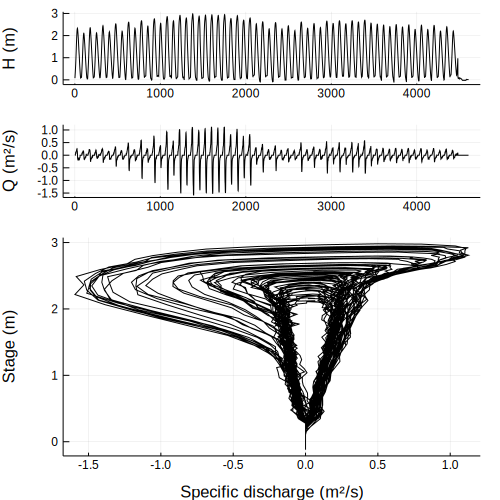

In [26]:
# We'll load data from Sweeney Creek
H,Q = load_data("sweeney",2)

# And plot it up
plot(layout=grid(3,1,heights=[0.2;0.2;0.6]),
    plot(H,ylabel="H (m)",c=:black,leg=false),
    plot(Q,ylabel="Q (m²/s)",c=:black,leg=false),
    plot(Q,H,c=:black,leg=false, xlabel="Specific discharge (m²/s)",ylabel="Stage (m)"),
    size=(500,500)
    )

Note that the stage-discharge plot looks very different from the data in a river. First, there are flows in two directions, positive discharges on the flood tide and negative discharges on the ebb tide. Also, the fortnightly spring-neap tidal cycle means that one water level corresponds to many different discharges, depending on how fast the tide is rising.

The USGS rating curve is a nonlinear function, but it is ultimately just a fancy kind of linear regression. What happens if we fit a linear regression to our stage-discharge data?

In [28]:
# This code fits a linear regression of order k to the data (X,Y)
struct PolynomialRegression
    X
    Y
    H
    β
    k
end

function StatsBase.fit(::Type{PolynomialRegression},X,Y,k=1)
    H = hcat([X.^i for i in 0:k]...)
    β = H\Y
    PolynomialRegression(X,Y,H,β,k)
end
StatsBase.predict(m::PolynomialRegression) = m.H*m.β
StatsBase.predict(m::PolynomialRegression,x) = hcat([x.^i for i in 0:m.k]...)*m.β

In [29]:
m1 = fit(PolynomialRegression,H,Q,1)

PolynomialRegression([0.0760797, 0.133761, 0.203376, 0.270008, 0.332662, 0.408244, 0.481838, 0.553442, 0.629025, 0.716541  …  0.0114368, 0.0114368, 0.0104423, 0.0114368, 0.0124313, 0.0114368, 0.0104423, 0.0104423, 0.0114368, 0.0084533], [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0319917, 0.0453467, 0.0309693, 0.076218, 0.0703522  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0 0.0760797; 1.0 0.133761; … ; 1.0 0.0114368; 1.0 0.0084533], [-0.0188003, 0.0173406], 1)

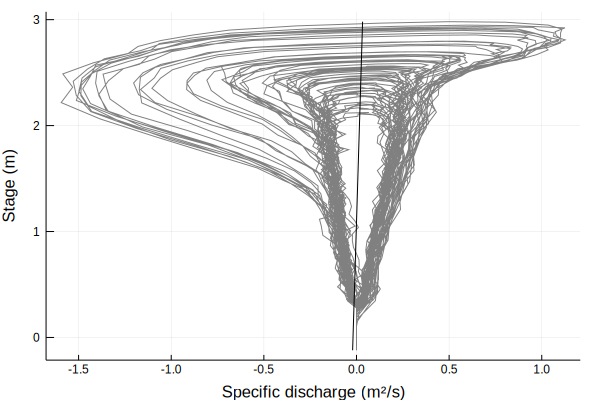

In [34]:
plot(Q,H,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(m1,sort(H)),sort(H),c=:black)

Not surprisingly, the linear regression draws a line through the data points. But because there are both flood and ebb discharges, we get a vertical line pretty close to zero. This is one of the major challenges of rating curve development in tidal environments: Estimating a discharge of zero all the time is not all that bad, but is pretty useless if we want to estimate fluxes of sediment or nutrients into the marsh.

But wait! We know that rating curves in general are nonlinear, look at the Palmyra curve, for example. We tried a first-order linear regression above, but what if we let it be quadratic or cubic? That's easy enough to try: when you see the line 

```julia
fit(PolynomialRegression,H,Q,1)
```

that `1` is the highest order of the polynomial regression. Try changing it to another positive integer and see what you can make happen. Remember click in the code cell to edit it, `Shift-Enter` to run the cell that fits the model, then `Shift-Enter` again to run the cell that makes the plot.

Congratulations! You've just fit your first machine learning model. Linear regression may seem pretty mundane, but it is very closely related to other regression algorithms used in machine learning, but significantly cheaper to fit. When in doubt, try a linear regression!

## Analyzing the performance of a model

We can see from the plot that the model doesn't look like the data, but how do we get a quantitative estimate of model performance that lets us compare different models?

One quantity that is pretty basic, but is used all over the place is the **mean-squared error**.

#### Mean-squared error

$$
MSE = \frac{1}{N} \sum_{i=1}^N \left(y_i-\hat{f}(x_i)\right)^2
$$

where $\hat{f}(x)$ is our estimated function, $x_i$ is each input data point and $y_i$ is the output data point.

We can calculate the MSE fairly easily.

In [92]:
# `msd(Y,Ŷ)` means "mean squared deviation". 
# It calculates the MSE between Y and Ŷ.
msd(Q,predict(m1,H))

0.08896100122840976

The mean squared error (for our stage-discharge models) is in units of $\mathrm{m^4\cdot{}s^{-2}}$, which is a little confusing, so you often see people take the square root, to get it into the same units as your output ($\mathrm{m^2 \cdot{} s^{-1}}$). We do that with `rmsd`

In [93]:
rmsd(Q,predict(m1,H))

0.2982633085520406

We noted above that estimating discharge with zero (or something like the mean discharge) is not all that bad. So one way to compare models is to see how they perform relative to the constant model. We can do this with a metric called the **Nash-Sutcliffe efficiency**.

#### Nash-Sutcliffe Efficiency

$$
NSE = 1 - \frac{\sum_{t=1}^T (Q_m^t - Q_o^t)^2}{\sum_{t=1}^T (Q_o^t - \overline{Q_o})^2}
$$

where now $Q_m^t$ is the modeled discharge at time $t$, $Q_o^t$ is the observed discharge at time $t$, and $\overline{Q_o}$ is the mean of the discharge over the time series.

In [94]:
function nse(Qo,Qm)
   1. -sum(abs2,Qm-Qo)./sum(abs2,Qo.-mean(Qo)) 
end

nse (generic function with 1 method)

NSE is quite similar to $R^2$, which you may have used before, except that it can range from $-\infty$ to 1. An NSE of 1 is a perfect fit. An NSE of 0 means that you get the same mean squared error as estimating the discharge using the mean. A negative NSE, means you're doing worse than estimating with the mean. This can happen when you're using complicated models, and we should see some examples in the future.

When we compute the NSE for the linear regression, we see that it is pretty close to zero. The linear regression model is not much better than just using the mean of the data (because a linear regression in a tidal system is just using the mean of the data).

In [95]:
nse(Q,predict(m1,H))

0.0027811269735386057

# A classical semi-empirical tidal stage-discharge model

It is clear from our analysis above that we'll need to go beyond a linear regression to come up with a good stage-discharge model. One approach that was taken by John Boon in the 1970s, is to approximate the equations of motion governing flow in shallow water. We won't go through the derivation, because it is easy to understand intuitively.

The main assumption made by Boon is that the water surface everywhere in our marsh is flat.

![](figures/boonModel.png)

As the tide rises, enough water flows into it to fill up the entire marsh to the new water level.

![](figures/boonModel2.png)

And the process is reversed as the tide falls. This gives us a model for the water level and discharge

$$
Q(t) = A(H)\frac{dH}{dt}
$$

where $A(H)$ is the **hypsometric curve**, which tells you how much area you need to fill in to bring the water level to $H$. The hypsometric curve depends on the topography of the marsh, which we could, in principle, estimate using remote sensing data. But we don't need to do that, because we can use our stage-discharge data to estimate the function $A(H)$.

For completeness, our model for discharge is

$$
\hat{Q}_i = \alpha |H_i|^{\beta} \cdot (H_i-H_{i-1})
$$

where $\alpha$ and $\beta$ are the coefficients that we fit. We have approximated the function $A(H)$ as a power law, because power law hypsometric curves are fairly good approximations of what we see in nature, and it keeps the computation tractable. We have approximated the time derivative $dH/dt \approx H_i - H_{i-1}$. This means that we won't be able to estimate the discharge at time step $i=1$, because we don't have $H_0$, so we'll fit the model by minimizing the mean squared error between the modeled and observed discharges for the time steps $i \in \{2 \dots N\}$

In [110]:
struct BoonModel
    β
    H
    Q
end

boon(h,β) = β[1]*abs(h[1]).^β[2]*(h[2]-h[1])
function boon(H::AbstractMatrix,β)
    Q = zeros(size(H,1))
    for i in 1:length(Q)
        Q[i] = boon(H[i,:],β)
    end
    Q
end
ssr(H,Q,β) = 0.5*msd(Q,boon(H,β))

function StatsBase.fit(::Type{BoonModel},H,Q)
    Hm = [H[1:end-1] H[2:end]]
    opt = optimize(β->ssr(Hm,Q[2:end],β),zeros(2))
    β = Optim.minimizer(opt)
    BoonModel(β,H,Q)
end

StatsBase.predict(m::BoonModel) = predict(m,m.H)
StatsBase.predict(m::BoonModel,H) = boon([H[1:end-1] H[2:end]],m.β)

In [111]:
m2 = fit(BoonModel,H,Q)

BoonModel([0.0638264, 5.60969], [0.0760797, 0.133761, 0.203376, 0.270008, 0.332662, 0.408244, 0.481838, 0.553442, 0.629025, 0.716541  …  0.0114368, 0.0114368, 0.0104423, 0.0114368, 0.0124313, 0.0114368, 0.0104423, 0.0104423, 0.0114368, 0.0084533], [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0319917, 0.0453467, 0.0309693, 0.076218, 0.0703522  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

### Performance of the Boon model

In [112]:
rmsd(Q[2:end],predict(m2,H))

0.11300043965539351

In [113]:
nse(Q[2:end],predict(m2,H))

0.8568943513217551

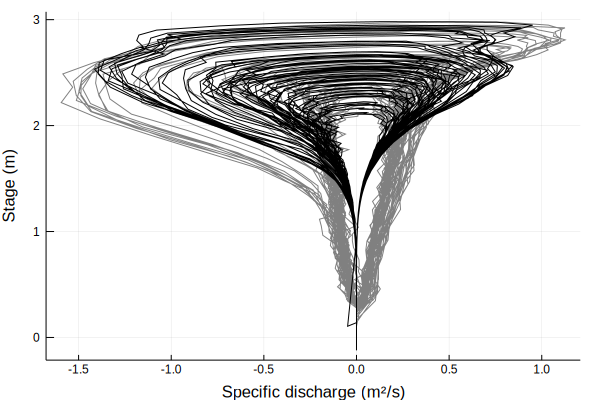

In [114]:
plot(Q,H,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(m2,H),H[2:end],c=:black)

Our Nash-Sutcliffe efficiency is up to 0.86! That's pretty good, but we can see from the plot that we don't do a great job of estimating the asymmetry between flood and ebb tides. That asymmetry is especially important if we want to get a good estimate of the balance between sediment being brought in on the flood tide and brought out on the ebb tide.

# A linear time series model

If you look closely at the expression for the Boon model, it looks rather like a linear regression on lagged values of the water level.

$$
Q_i = A(H_i)\cdot(H_i - H_{i-1}) = A(H_i)\cdot H_i - A(H_i)\cdot H_{i-1}
$$

except the regression coefficient $A(H_i)$ is itself a function of $H_i$, making this a **nonlinear regression**.

From this perspective, we can see two ways that we might make the Boon model a little more flexible, letting it fit a more complex stage-discharge relationship.

- We could look further back in time
- We could add nonlinearity

Let's first examine the first option. Looking further back in time might help us account for the phase lag between stage and discharge that causes the tidal asymmetry. The reasons for this rely on some dynamical systems theory that is pretty complicated, but you don't have to take my word for it, let's try it out!

We'll use a linear time invariant model that is commonly used in signal processing. This is just a multiple linear regression on lagged values of stage. It comes with one parameter that you can tune: the number of lags that you want to consider. 

In [47]:
# This code will fit a linear time invariant model
struct LinearTimeInvariant
    n
    β
    H
    Q
end

function StatsBase.fit(::Type{LinearTimeInvariant},H,Q,n=1)
    N = length(H)
    Hm = zeros(N-n+1,n)
    for i in 1:n
        Hm[:,i] = H[i:N-(n-i)] 
    end
    β = Hm\Q[n:end]
    LinearTimeInvariant(n,β,H,Q)
end

function StatsBase.predict(m::LinearTimeInvariant,H)
    N = length(H)
    Hm = zeros(N-m.n+1,m.n)
    for i in 1:m.n
        Hm[:,i] = H[i:N-(m.n-i)] 
    end
    Hm*m.β
end

In [48]:
m3 = fit(LinearTimeInvariant,H,Q,75)

LinearTimeInvariant(75, [-0.123558, 0.0777677, 0.014495, -0.00793681, -0.0276842, -0.0127296, -0.000300953, 0.03081, 0.0496616, 0.0747601  …  0.0738116, 0.0765367, 0.0667283, 0.070742, 0.00132617, -0.083826, -0.160256, -0.233567, -0.567278, 0.901098], [0.0760797, 0.133761, 0.203376, 0.270008, 0.332662, 0.408244, 0.481838, 0.553442, 0.629025, 0.716541  …  0.0114368, 0.0114368, 0.0104423, 0.0114368, 0.0124313, 0.0114368, 0.0104423, 0.0104423, 0.0114368, 0.0084533], [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0319917, 0.0453467, 0.0309693, 0.076218, 0.0703522  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

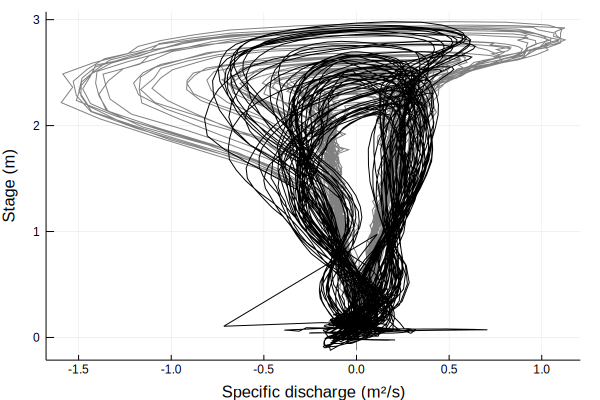

In [49]:
plot(Q,H,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(m3,H),H[m3.n:end],c=:black)

In [50]:
nse(Q[m3.n:end],predict(m3,H))

0.6049411299380704

That doesn't seem to work quite as well as the Boon model, but we do get a little more asymmetry between flood and ebb.

## The importance of cross validation

I gave you a starting value for the number of lags of 75. These data are recorded at 10 minute intervals, so 75 time steps is approximately one tidal cycle. Try increasing the number of lags. How does the performance change? Try looking at 2000 lags.

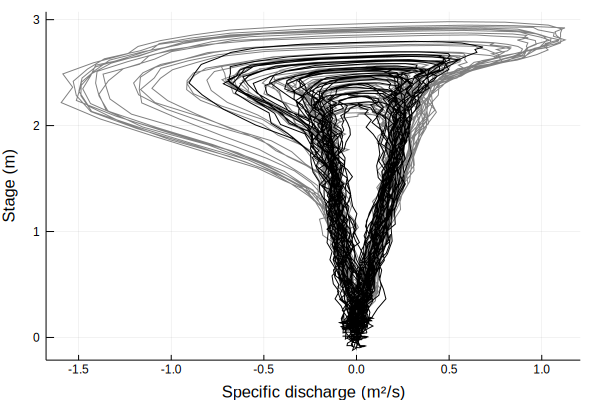

In [51]:
m4 = fit(LinearTimeInvariant,H,Q,2000)
plot(Q,H,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(m4,H),H[m4.n:end],c=:black)

That does a pretty good job, right? 

It does a pretty good job **on the training data**, the data that we have used to fit the model. With most machine learning models, you'll have a tuning parameter that controls how many parameters the model fits. Here we have one parameter per lag. Generally you'll be able to fit more and more complicated functions with more and more parameters. So why don't we always use as many parameters as we can? Let's try to apply our model to some new data from the same marsh and see what happens.

In [53]:
Ht,Qt = load_data("sweeney",4)

([0.383382, 0.473882, 0.559409, 0.650904, 0.746376, 0.845164, 0.962184, 1.07456, 1.18595, 1.31424  …  1.538, 1.45645, 1.37888, 1.29534, 1.21081, 1.13026, 1.05732, 0.986715, 0.901519, 0.827594], [0.0747887, 0.0545908, 0.0241249, 0.0825033, 0.0558494, 0.0941623, 0.100762, 0.14242, 0.125234, 0.141565  …  -0.154709, -0.162606, -0.145739, -0.145762, -0.137363, -0.132978, -0.119191, -0.12617, -0.117811, -0.0985799])

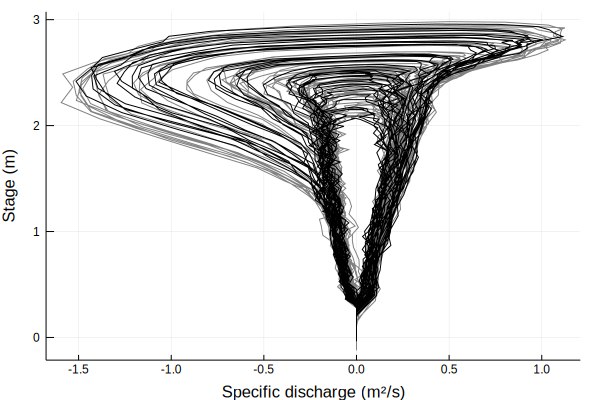

In [56]:
plot(Q,H,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(Qt,Ht,c=:black)

We can see that the shape of the stage-discharge relationship is pretty consistent across deployments in the same marsh. So our giant linear time invariant model that works great on the training data should work well on the new **test data**, right?

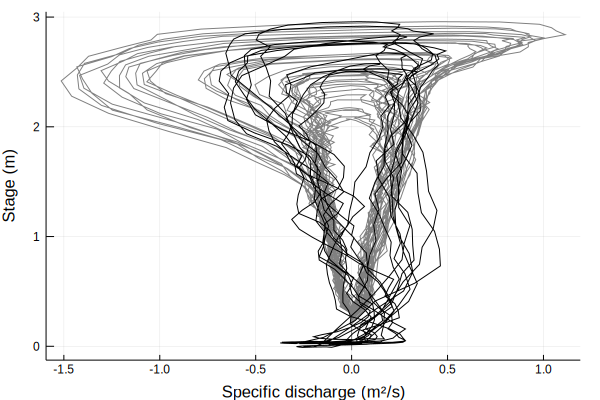

In [57]:
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(m4,Ht),Ht[m4.n:end],c=:black)

This is an example of **overfitting**. We can fit the training data arbitrarily closely by increasing the number of parameters, but we end up fitting the model to unique features of the training data that don't show up in the test data. The common example given for overfitting is trying to fit a high-order polynomial regression to a few data points:

### Overfitting

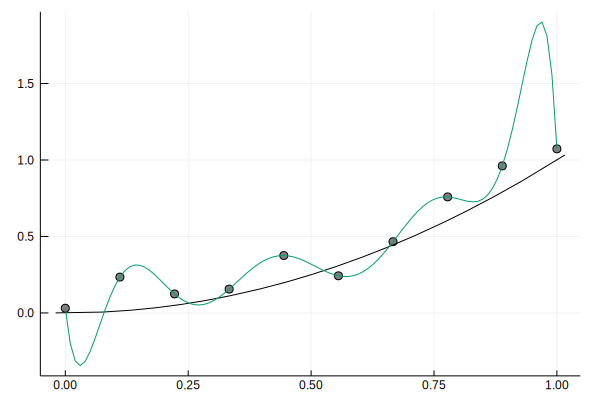

In [59]:
x = range(0,stop=1,length=10)
xt = range(0,stop=1,length=100)
y = x.^2 + 0.1*randn(10)
scatter(x,y,leg=false,c=:grey)
m10 = fit(PolynomialRegression,x,y,10)
plot!(x->x^2,c=:black)
plot!(xt,predict(m10,xt))

Here the true function is in black. The overfit function is in green. It has a mean squared error of zero because it interpolates perfectly through the data, but if you got more data from the same system (falling along the black line), you would do a pretty bad job. The same thing happens when we fit a really large linear time invariant model to our stage-discharge data.

So how can we make sure that we aren't overfitting? **Cross validation** is the formal name for what we've just done. We take another data set that we haven't used in estimating the model, apply the model to it and compute our performance metrics. Let's do that now with our big LTI model and our test data.

#### Training performance of the big LTI model

In [61]:
nse(Q[m4.n:end],predict(m4,H))

0.945728459415424

#### Test performance of the big LTI model

In [62]:
# And compute the test NSE
nse(Qt[m4.n:end],predict(m4,Ht))

0.6148421167757108

To see this overfitting in action, we can compute the test NSE for models of many different sizes. This might take a little while.

In [63]:
nse_lti = [nse(Qt[n:end],
        predict(fit(LinearTimeInvariant,H,Q,n),Ht)) 
    for n in 1:75:2000]

27-element Array{Float64,1}:
 -0.004116012748817788
  0.6705675820523769  
  0.7709566503490755  
  0.7738658333908583  
  0.7784861774963656  
  0.778578809129074   
  0.7823060049715911  
  0.7858572285505527  
  0.7912619986498022  
  0.7985984674997888  
  0.8026178640877598  
  0.8071737905608313  
  0.8082240846401743  
  ⋮                   
  0.8039572680708833  
  0.8014633135925906  
  0.8021676881967134  
  0.7968078196807051  
  0.7829325291639406  
  0.7700023453168217  
  0.7556764741629002  
  0.7466641290288886  
  0.713990620338711   
  0.6882200600061018  
  0.6759905437291531  
  0.6463160150204776  

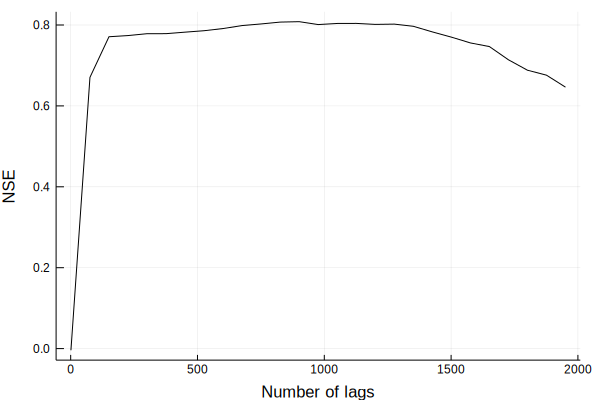

In [64]:
plot(1:75:2000,nse_lti,
    leg=false,c=:black,
    xlabel="Number of lags",
    ylabel="NSE"
)

That peak and decline in the cross validated performance is characteristic of overfitting, so we will try to pick a number of lags somewhere in the area before the test performance starts to decline.

Another commonly used form of cross-validation is called **k-fold cross validation**, where you divide your data into k subsets, fit the model to the data from k-1 of the subsets and test it on the remaining subset that you held out. This is more robust, essentially because you average over some of the variability in your data. However, it gets computationally expensive fairly quickly, so we'll stick with our simple cross validation.

One last question: what do the predictions from that optimal model look like?

#### Cross-validated LTI performance

In [71]:
n_optimal = (1:75:2000)[findmax(nse_lti)[2]]
lti_900 = fit(LinearTimeInvariant,H,Q,900)

nse(Qt[lti_900.n:end],predict(lti_900,Ht))

0.8083556480687055

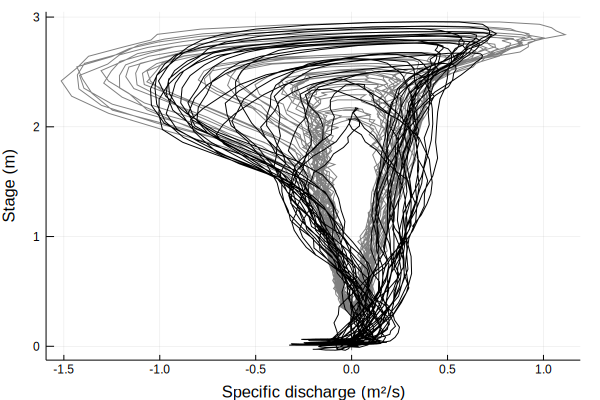

In [72]:
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(lti_900,Ht),Ht[lti_900.n:end],c=:black)

The Nash-Sutcliffe efficiency is 0.81, which is slightly worse than the Boon model. Just adding more memory to the model is not going to get us any better results.

# A nonlinear time series model

When we were looking at extensions of the Boon model, I mentioned that there were two ways to extend it. Either we could add more memory to the model, hoping to correct the phase lags that we see in the Boon model, or we could add more nonlinearity to the model, because we know from the physics that nonlinearities in tidal propagation generate the phase lags.

Remember the kernel trick that allowed us to correctly classify the bullseye data set?

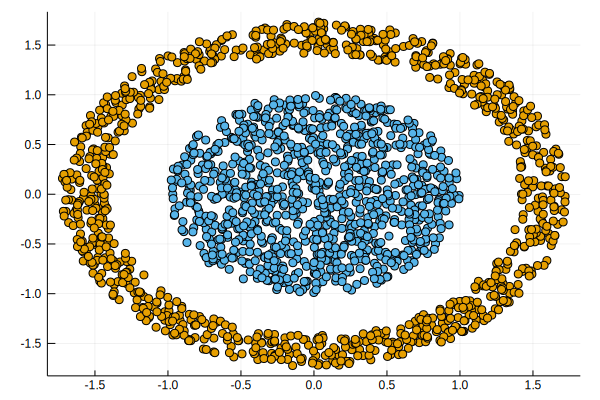

In [73]:
p = plot(leg=false)
scatter!(D[1,kmeans_assignments2.==1],D[2,kmeans_assignments2.==1])
scatter!(D[1,kmeans_assignments2.==2],D[2,kmeans_assignments2.==2])

We can do the same thing to our linear time-invariant model to create a nonlinear time-invariant model. We could use the Gaussian kernel that we used above, but an inhomogeneous polynomial kernel

$$
k_p(x,y) = (x^Ty + 1)^p
$$

lets us interpret this particular model as Volterra series , which is a commonly used nonlinear extension for linear time series models. However, it is important to remember that there isn't really anything special about time series. All we are doing is a nonlinear regression using our kernel trick. Because we do the regression on lagged values of the stage, we get a time series model that happens to be equivalent to the Volterra series.

In [74]:
# This code will fit a Volterra series model
struct RegularizedVolterra
    n
    λ
    p
    β
    H
    Q
end

# This is our kernel function, written two ways.
k2(x,y,p=2) = (x'y+1.0).^p
k2(d,p=2) = (d+1).^p

function kernel_matrix(H1,H2,n,p)
    N = length(H1)
    M = length(H2)
    H1m = zeros(N-n+1,n)
    H2m = zeros(M-n+1,n)

    for i in 1:n
        H1m[:,i] = H1[i:N-(n-i)] 
        H2m[:,i] = H2[i:M-(n-i)] 
    end
    
    k2.(H1m*H2m',p)
end

kernel_matrix(H,n,p) = kernel_matrix(H,H,n,p)

kernel_matrix(m::RegularizedVolterra,H) = kernel_matrix(m.H,H,m.n,m.p)

function StatsBase.fit(::Type{RegularizedVolterra},H,Q,n=1,p=1,λ=0.0)
    N = length(H)
    β = (kernel_matrix(H,n,p) + λ*I)\Q[n:end]
    RegularizedVolterra(n,λ,p,β,H,Q)
end

function StatsBase.predict(m::RegularizedVolterra,H)
    N = length(H)
    Hm = zeros(N-m.n+1,m.n)
    for i in 1:m.n
        Hm[:,i] = H[i:N-(m.n-i)] 
    end
    kernel_matrix(m,H)'m.β
end

#### Choosing the Volterra model parameters 

The Volterra series model has three parameters, the number of lags, an order of nonlinearity and a regularization parameter that we'll get to. For now, we can stick with 75 lags, which is about one tidal cycle.

Like when we looked at lags, more nonlinearity lets us fit a more complex model, but eventually we will start to overfit, so we should probably use cross valiation to select our model order.

In [75]:
nse_volterra_order = [nse(Qt[75:end],
        predict(fit(RegularizedVolterra,H,Q,75,p),Ht)) 
    for p in 1:10]

10-element Array{Float64,1}:
 -1914.8608912532748     
   -21.974690193059693   
     0.8756989363847099  
     0.767476535121685   
     0.5691889574734043  
     0.540819594845391   
     0.4831053902420558  
     0.38717610969262284 
     0.24033836555288923 
     0.024437561957135423

The best NSE (0.88. A little better than the Boon model!) comes from an order of 3, so we'll fit that and see what happens.

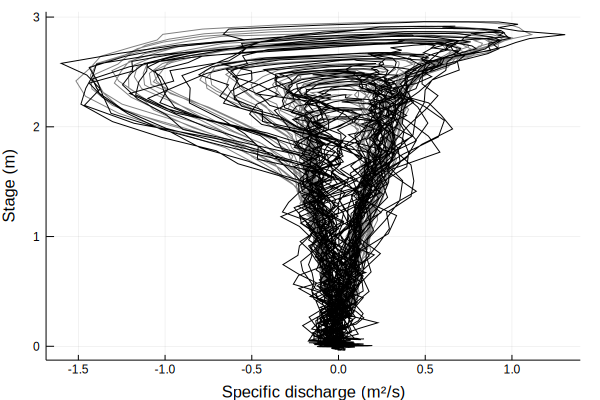

In [76]:
mV1 = fit(RegularizedVolterra,H,Q,75,3,0.0)
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(mV1,Ht),Ht[mV1.n:end],c=:black)

It seems to get the asymmetry and magnitudes of the discharges right, but it seems really noisy, right?

This noise is another symptom of overfitting. To check, see how well the same model does on the training data:

#### Volterra series training performance

In [77]:
nse(Q[75:end],predict(mV1,H))

0.9999999999281108

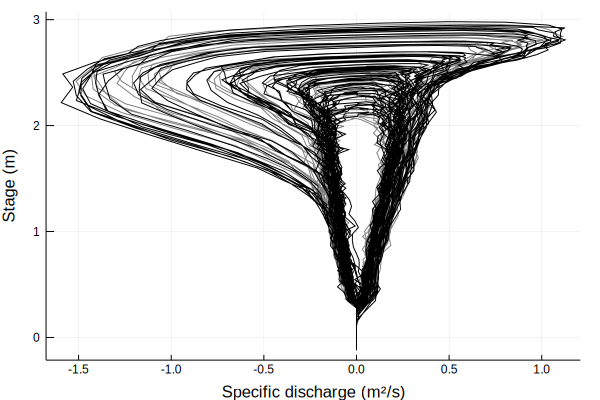

In [78]:
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(mV1,H),H[mV1.n:end],c=:black)

That's almost perfect! So the noise must come down to overfitting. We have a few options to play with, here. We could reduce the number of lags or the order of the nonlinearity, but that won't help us very much in the end, and it might even make things worse (we have chosen our nonlinearity by cross validation, after all).

## Regularization

The solution is to use **regularization**, which is a technique to prevent overfitting by forcing your algorithm to prefer smoother functions. The mathematical details of how regularization works are not super illuminating without a solid background in linear algebra, but the gist is that you introduce an extra parameter that controls the tradeoff between fitting the data and a smoother estimate. A higher setting of this parameter leads to smoother functions but will fit the data worse. Obviously there is an optimum, and we can use cross validation to find it.

To see how regularization works, let's play with the overfit polynomial that we saw earlier.

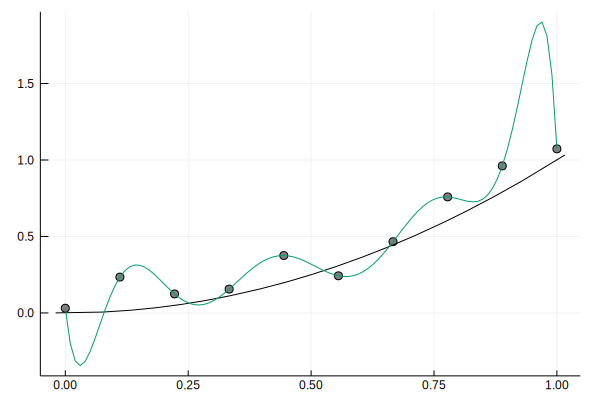

In [79]:
scatter(x,y,leg=false,c=:grey)
plot!(x->x^2,c=:black)
plot!(xt,predict(m10,xt))

In [80]:
struct RegularizedPolynomialRegression
    X
    Y
    H
    β
    λ
    k
end

function StatsBase.fit(::Type{RegularizedPolynomialRegression},X,Y,k=1,λ=0)
    H = hcat([X.^i for i in 0:k]...)
    β = (H'H +λ*I)\(H'Y)
    RegularizedPolynomialRegression(X,Y,H,β,λ,k)
end
StatsBase.predict(m::RegularizedPolynomialRegression) = m.H*m.β
StatsBase.predict(m::RegularizedPolynomialRegression,x) = hcat([x.^i for i in 0:m.k]...)*m.β

Now we can play around with the regularization parameter. Try a few values out an see what happens. Remember that the regularization parameter is always greater than or equal to 0, and a value of 0 means no regularization (i.e. identical to the model that we fit above). 

If we really wanted to choose the "right" value of the regularization parameter, we would, of course, cross validate.

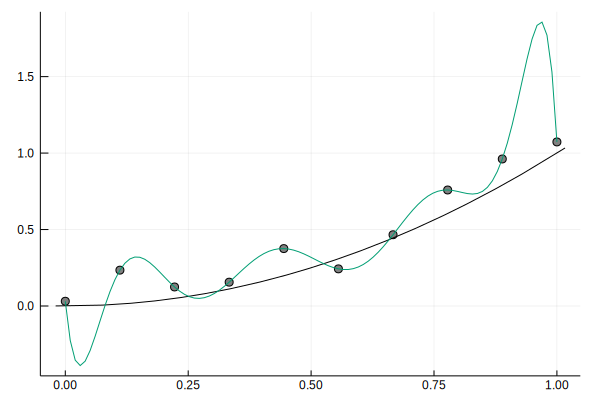

In [86]:
# The regularization parameter is the last number on the next line.
m10r = fit(RegularizedPolynomialRegression,x,y,10,0.0)

scatter(x,y,leg=false,c=:grey)
plot!(x->x^2,c=:black)
plot!(xt,predict(m10r,xt))

Remember that we can prevent overfitting in this polynomial regression by using a smaller order of the polynomial, but unless our data actually follow a low-order polynomial, we may not fit our data particularly well.

Regularization lets us use a really flexible model that is capable of capturing all of the interesting behavior in the data but also control its tendency to overfit.

Since the Volterra series model is just a linear regression with the kernel trick applied, we can add a regularization parameter exactly the same way.

You can play with adjusting the regularization parameter here.

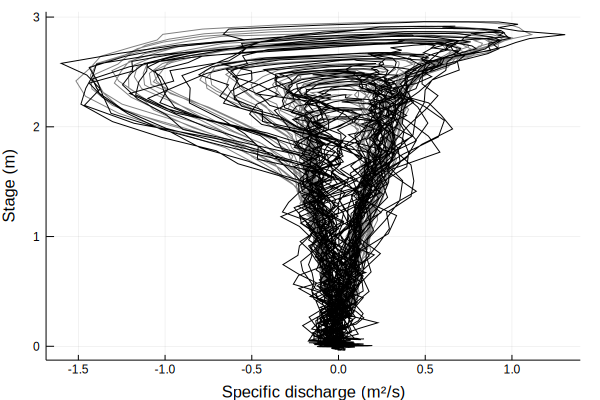

In [90]:
# The regularization parameter is the last number on this line.
mVr = fit(RegularizedVolterra,H,Q,75,3,0.0)
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(mVr,Ht),Ht[mVr.n:end],c=:black)

And finally, we said we would pick the parameters of our regularized Volterra series model by cross validation, so let's do that. Let's fix the number of lags at 75 (otherwise this will take forever) and then try several values of the nonlinearity and regularization parameters.

In [156]:
λs = exp10.(range(-3,stop=6,length=10))
ps = 1:5
nse_volterra = [
    nse(Qt[75:end],
        predict(fit(RegularizedVolterra,H,Q,75,p,λ),Ht)) 
    for p in ps, λ in λs]

# `findmax` finds the maximum value in an array
findmax(nse_volterra)

(0.948239536778377, CartesianIndex(3, 6))

So our best NSE is around 0.95 (on the **test data**) and it occurs at $p=3$ and $\lambda=100$.

Let's see what it looks like:


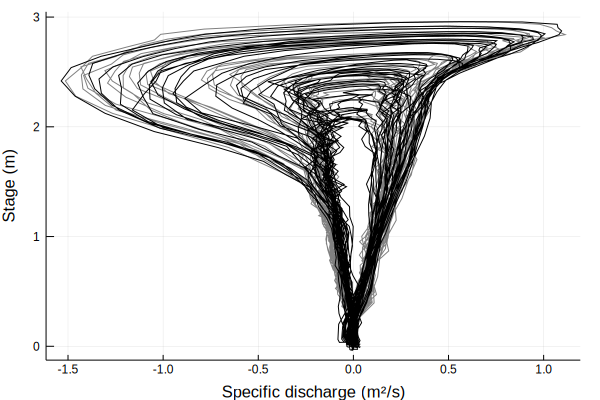

In [91]:
mVr_CV = fit(RegularizedVolterra,H,Q,75,3,100.0)
plot(Qt,Ht,
    c=:grey,leg=false,
    xlabel="Specific discharge (m²/s)",
    ylabel="Stage (m)")
plot!(predict(mVr_CV,Ht),Ht[mVr_CV.n:end],c=:black)

Pretty good!

# Conclusions

- Machine learning is basically just fitting statistical models to data, but it provides tools like **the kernel trick**, **cross validation** and **regularization** that let us build far more complicated models than classical statistics provides.
- The stage-discharge modeling problem illustrates one route to solving an environmental data analysis problem:
    - Start with simple models like a linear regression or the Boon model.
    - Add complexity by looking at more information (more lags) or more complex models (more nonlinearity)
    - Test models with cross validation
    - Regularize

# Resources

A lot of what I know about building and testing complex models comes from Cosma Shalizi's book [*Advanced Data Analysis from an Elementary Point of View*](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf), but it does requires a solid understanding of basic statistics, particularly linear regression.

If you want to learn more about stage-discharge models, check out this paper:

Kearney, W. S., Mariotti, G., Deegan, L. A. and Fagherazzi, S. 2017. Stage-discharge relationship in tidal channels. *Limnology and Oceanography: Methods*. https://doi.org/10.1002/lom3.10168 

The seminal paper on discharge asymmetry by John Boon is

Boon, J. D. Tidal discharge asymmetry in a salt marsh drainage system. 1975. *Limnology and Oceanography*. https://doi.org/10.4319/lo.1975.20.1.0071

The Volterra series model and its links to kernel regression are explored in

Franz, M. O. and Schölkopf, B. 2006. A unifying view of Wiener and Volterra theory and kernel polynomial regression. *Neural Computation*. https://doi.org/10.1162/neco.2006.18.12.3097